## Reinforcement Learning Workshop
In this workshop, we are going to train a model to find the safest path from the start to end locations on a frozen lake.

In [2]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from collections import defaultdict
import copy 
import matplotlib.animation as animation
import time

### Function Definitions

In [3]:
"""
Create a heatmap of the Q values per state.
"""
def createHeatMap(q_value_snapshots, snapshot_intervals, env):
    cols = 2  # Number of columns
    rows = 3  # Fixed to 2 rows
    all_q_values = np.concatenate([
        np.array([list(snapshot.get(state, np.zeros(env.action_space.n))) for state in range(env.observation_space.n)])
        for snapshot in q_value_snapshots
    ])
    vmin, vmax = np.min(all_q_values), np.max(all_q_values)

    # Create subplots with 2 rows
    fig, axes = plt.subplots(rows, cols, figsize=(10, 15))  # Adjust height to fit better
    axes = axes.flatten()  # Flatten axes for easier indexing

    for i, q_snapshot in enumerate(q_value_snapshots):
        q_table_array = np.zeros((env.observation_space.n, env.action_space.n))
        
        for state in range(env.observation_space.n):
            q_table_array[state] = q_snapshot.get(state, np.zeros(env.action_space.n))  # Ensure all states exist

        sns.heatmap(q_table_array, annot=True, cmap="coolwarm", cbar=True, ax=axes[i], vmin=vmin, vmax=vmax)
        axes[i].set_title(f"Q-values at Episode {snapshot_intervals[i]}")
        axes[i].set_xlabel("Actions (0=Left, 1=Down, 2=Right, 3=Up)")
        axes[i].set_ylabel("States")

    # Hide any unused subplots (if len(q_value_snapshots) is odd)
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.suptitle("Q-value Evolution Over Training", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
    plt.show()
    createHeatMapAnimation(q_value_snapshots, snapshot_intervals, env)

"""
Creates an animation of the heat map (created above) evolving over episodes.
"""
def createHeatMapAnimation(q_value_snapshots, snapshot_intervals, env):
    fig, ax = plt.subplots(figsize=(6, 5))

    # Find global min and max values for consistent color scaling
    all_q_values = np.concatenate([
        np.array([list(snapshot.get(state, np.zeros(env.action_space.n))) for state in range(env.observation_space.n)])
        for snapshot in q_value_snapshots
    ])

    vmin, vmax = np.min(all_q_values), np.max(all_q_values)  # Fixed color range

    # Initialize first Q-table
    q_table_array = np.zeros((env.observation_space.n, env.action_space.n))

    # Create the initial heatmap with fixed vmin, vmax
    heatmap = sns.heatmap(q_table_array, annot=True, cmap="coolwarm", cbar=True, ax=ax, vmin=vmin, vmax=vmax)
    cbar = heatmap.collections[0].colorbar  # Store the colorbar reference

    def update(frame):
        """Update the heatmap for each frame without changing the color scale."""
        q_snapshot = q_value_snapshots[frame]

        # Update Q-table array with the new snapshot
        for state in range(env.observation_space.n):
            q_table_array[state] = q_snapshot.get(state, np.zeros(env.action_space.n))  # Ensure all states exist

        # Clear old heatmap but keep the color scale
        ax.clear()

        # Redraw heatmap with consistent color scale
        sns.heatmap(q_table_array, annot=True, cmap="coolwarm", cbar=False, ax=ax, vmin=vmin, vmax=vmax)

        ax.set_title(f"Q-values at Episode {snapshot_intervals[frame]}")
        ax.set_xlabel("Actions (0=Left, 1=Down, 2=Right, 3=Up)")
        ax.set_ylabel("States")

    # Create the animation
    anim = animation.FuncAnimation(fig, update, frames=len(q_value_snapshots), repeat=True)

    # Save as GIF
    gif_filename = "q_table_animation.gif"
    anim.save(gif_filename, writer=animation.PillowWriter(fps=1))
    print(f"✅ Animation saved as {gif_filename}")

"""
Creates a heatmap of the number of times the model visits each state. 
"""
def visualizeStateVisits(state_visits, env):
    visit_grid = np.zeros((4, 4))
    
    for state, visits in state_visits.items():
        visit_grid[state // 4, state % 4] = visits

    plt.figure(figsize=(5, 5))
    sns.heatmap(visit_grid, annot=True, cmap="Greens", fmt=".0f")
    plt.title("State Visit Frequency")
    plt.show()
    return visit_grid

""" 
Plots the smoothed reward over episodes.
"""
def plotRewards(reward_history, window_size=100):
    """ Line plot of total rewards over episodes with smoothing. """
    smoothed_rewards = np.convolve(reward_history, np.ones(window_size)/window_size, mode='valid')

    plt.figure(figsize=(10, 5))
    plt.plot(smoothed_rewards, label=f"Smoothed Rewards (window={window_size})", color="blue", linewidth=2)
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.title("Training Progress - Smoothed Rewards Over Time")
    plt.legend()
    plt.show()
    return smoothed_rewards

"""
Plots the best direction for each state.
"""
def getBestActionsPerState(env, Q, ACTION_MAP):
    policy_grid = np.full((4, 4), ' ', dtype=str)
    for state in range(env.observation_space.n):
        best_action = np.argmax(Q[state])
        policy_grid[state // 4, state % 4] = ACTION_MAP[best_action]

    print("\nBest Actions Learned by Q-Learning:")
    for row in policy_grid:
        print("  ".join(row))

"""
    Function to compare variables across multiple categories in a dictionary,
    creating subplots for each key in the dictionary.
    
    :param data_dict: Dictionary where each key has a list of variables to plot.
    """
def compareAll(data_dict):    
    # Number of rows = number of keys in the dictionary
    num_rows = len(data_dict)
    
    # Number of columns = length of the longest list of values in the dictionary
    num_cols = max(len(values) for values in data_dict.values())
    
    # Create a figure and axis grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))
    
    # Ensure axes is 2D array for easier indexing
    if num_rows == 1:
        axes = axes.reshape(1, num_cols)
    if num_cols == 1:
        axes = axes.reshape(num_rows, 1)
    
    # Loop through the dictionary and plot
    for i, (key, values) in enumerate(data_dict.items()):
        # Loop through the values list of the current key and plot them
        for j, value in enumerate(values):
            ax = axes[i, j]
            if j == 0:
                sns.heatmap(value, ax=ax, annot=True, cmap="Greens", fmt=".0f")
            if j == 1:
                ax.plot(value)
            
            ax.set_title(f'{key} - Plot {j+1}')
            ax.set_xlabel('X-axis')
            ax.set_ylabel('Y-axis')
            
    # Adjust layout to prevent overlapping subplots
    plt.tight_layout()
    plt.show()

"""
Reinforcement learning model definition.
"""
def reinforcement_learning(alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.999, epsilon_min=0.1, episodes=5001, render_mode="ansi", render=False):
    ACTION_MAP = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    env = gym.make("FrozenLake-v1", is_slippery=False, render_mode=render_mode)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    q_value_snapshots = []  # Store Q-table at different intervals
    snapshot_intervals = np.linspace(0, episodes, 5, dtype=int).tolist()  # Capture Q-values at these episodes
    state_visits = defaultdict(int)  # Track state visit frequency
    reward_history = []  # Track total rewards per episode

    start_time = time.time()

    for episode in range(episodes):
        print(episode)
        state, _ = env.reset()
        done = False
        total_reward = 0  # Track cumulative reward for this episode

        while not done:

            state_visits[state] += 1  # 🔹 Track visits
            
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, done, _, _ = env.step(action)
            best_next_action = np.argmax(Q[next_state])
            Q[state][action] += alpha * (reward + gamma * Q[next_state][best_next_action] - Q[state][action])
            state = next_state

            total_reward += reward  # 🔹 Accumulate reward

        epsilon = max(epsilon * epsilon_decay, epsilon_min)  # Reduce exploration over time
        reward_history.append(total_reward)

        # 🔹 Store **actual copies** of Q-values at specific intervals
        if episode in snapshot_intervals:
            q_value_snapshots.append(copy.deepcopy(dict(Q)))  
    end_time = time.time()  # End time of the epoch
    final_time = end_time - start_time  # Store epoch time
    print("Reinforcement Learning - Q-Learning Training Complete")

    print("\nFrozenLake Map:")
    if (render):
        print(env.render())
    return env, Q, ACTION_MAP, q_value_snapshots, snapshot_intervals, state_visits, reward_history, final_time

    


##### Functions to compare changes in hyperparameter values

In [4]:

def compare_alpha_values(alpha_values, episodes=5001):
    plt.figure(figsize=(10, 6))
    times = []
    for alpha in alpha_values:
        print(f"Training with alpha = {alpha}")
        _, _, _, _, _, _, reward_history, finalTime = reinforcement_learning(alpha=alpha, episodes=episodes)
        times.append(finalTime)
        smoothed_rewards = np.convolve(reward_history, np.ones(100)/100, mode='same')
        plt.plot(smoothed_rewards, label=f'α = {alpha}')

    plt.title("Comparison of Performance with Different Alpha Values")
    plt.xlabel("Episodes")
    plt.ylabel("Cumulative Reward")
    plt.legend()
    plt.show()

    createPlot(alpha_values, times, "Alpha values", "Times", "Latency For Each Alpha Value")

def compare_gamma_values(gamma_values, episodes=5001):
    plt.figure(figsize=(10, 6))
    times = []
    for gamma in gamma_values:
        print(f"Training with gamma = {gamma}")
        _, _, _, _, _, _, reward_history, finalTime = reinforcement_learning(gamma=gamma, episodes=episodes)
        times.append(finalTime)  # Store epoch time
        smoothed_rewards = np.convolve(reward_history, np.ones(100)/100, mode='same')
        plt.plot(smoothed_rewards, label=f'gamma = {gamma}')

    plt.title("Comparison of Performance with Different Gamma Values")
    plt.xlabel("Episodes")
    plt.ylabel("Cumulative Reward")
    plt.legend()
    plt.show()
    createPlot(gamma_values, times, "Gamma values", "Times", "Latency For Each Gamma Value")

def compare_epsilon_values(epsilon_values, episodes=5001):
    plt.figure(figsize=(10, 6))
    times = []
    for epsilon in epsilon_values:
        print(f"Training with epsilon = {epsilon}")
        _, _, _, _, _, _, reward_history, finalTime = reinforcement_learning(epsilon=epsilon, episodes=episodes)
        times.append(finalTime)
        smoothed_rewards = np.convolve(reward_history, np.ones(100)/100, mode='same')
        plt.plot(smoothed_rewards, label=f'epsilon = {epsilon}')

    plt.title("Comparison of Performance with Different Epsilon Values")
    plt.xlabel("Episodes")
    plt.ylabel("Cumulative Reward")
    plt.legend()
    plt.show()
    createPlot(epsilon_values, times, "Epsilon values", "Times", "Latency For Each Epsilon Value")

def compare_epsilon_decay_values(epsilon_decay_values, episodes=5001):
    plt.figure(figsize=(10, 6))
    times = []
    for epsilon_decay in epsilon_decay_values:
        print(f"Training with epsilon_decay = {epsilon_decay}")
        _, _, _, _, _, _, reward_history, finalTime = reinforcement_learning(epsilon_decay=epsilon_decay, episodes=episodes)
        times.append(finalTime)  # Store epoch time
        smoothed_rewards = np.convolve(reward_history, np.ones(100)/100, mode='same')
        plt.plot(smoothed_rewards, label=f'Decay = {epsilon_decay}')

    plt.title("Comparison of Performance with Different Epsilon Decay Values")
    plt.xlabel("Episodes")
    plt.ylabel("Cumulative Reward")
    plt.legend()
    plt.show()
    createPlot(epsilon_decay_values, times, "Epsilon Decay values", "Times", "Latency For Each Epsilon Decay Value")
    

"""
Helper function to create plots.
"""
def createPlot(x, y, xlabel, ylabel, title):
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
        


#### Lets Visualize The Model Training

Here you will see how the model trains using reinforcement learning. In your own words, can you describe how reinforcement learning works? What are episodes? What marks the end of an episode? Do you think 10 episodes is enough?

In [5]:
env, Q, ACTION_MAP, q_value_snapshots, snapshot_intervals, state_visits, reward_history, _ = reinforcement_learning(render_mode="human", render=True, episodes=10)

0


2025-04-23 14:17:45.882 Python[71680:71003927] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-23 14:17:45.882 Python[71680:71003927] +[IMKInputSession subclass]: chose IMKInputSession_Modern


1
2
3
4
5
6
7
8
9
Reinforcement Learning - Q-Learning Training Complete

FrozenLake Map:
None


#### Analyze the model's performace

Each square on the map is referred to as a state starting with the top left as 0 and incrementing the state number as we move right and downwards. As a result, state 16 is the bottom right cube.

##### Description of each metric:

Best Actions: What direction the model recommends taking when at that location on the frozen lake

State Visit Frequency: The amount of times the model visited each state during the training process

Q-values Evolution: Shows the evolution of what direction the model recommends at each state. The direction with the highest value is what the model recommends the most, second highest value is second recommended direction, etc.

Smoothed Rewards: Every episode that the model successfuly gets to the goal, it gets a +1. If it doesn't get to the end it a 0. The smoothed rewards is the average of the previous `window_size` runs (in this case 1). 


Best Actions Learned by Q-Learning:
←  ←  ←  ←
←  ←  ←  ←
←  ←  ←  ←
←  ←  ←  ←


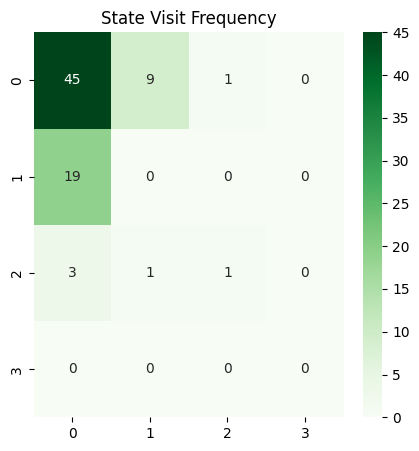

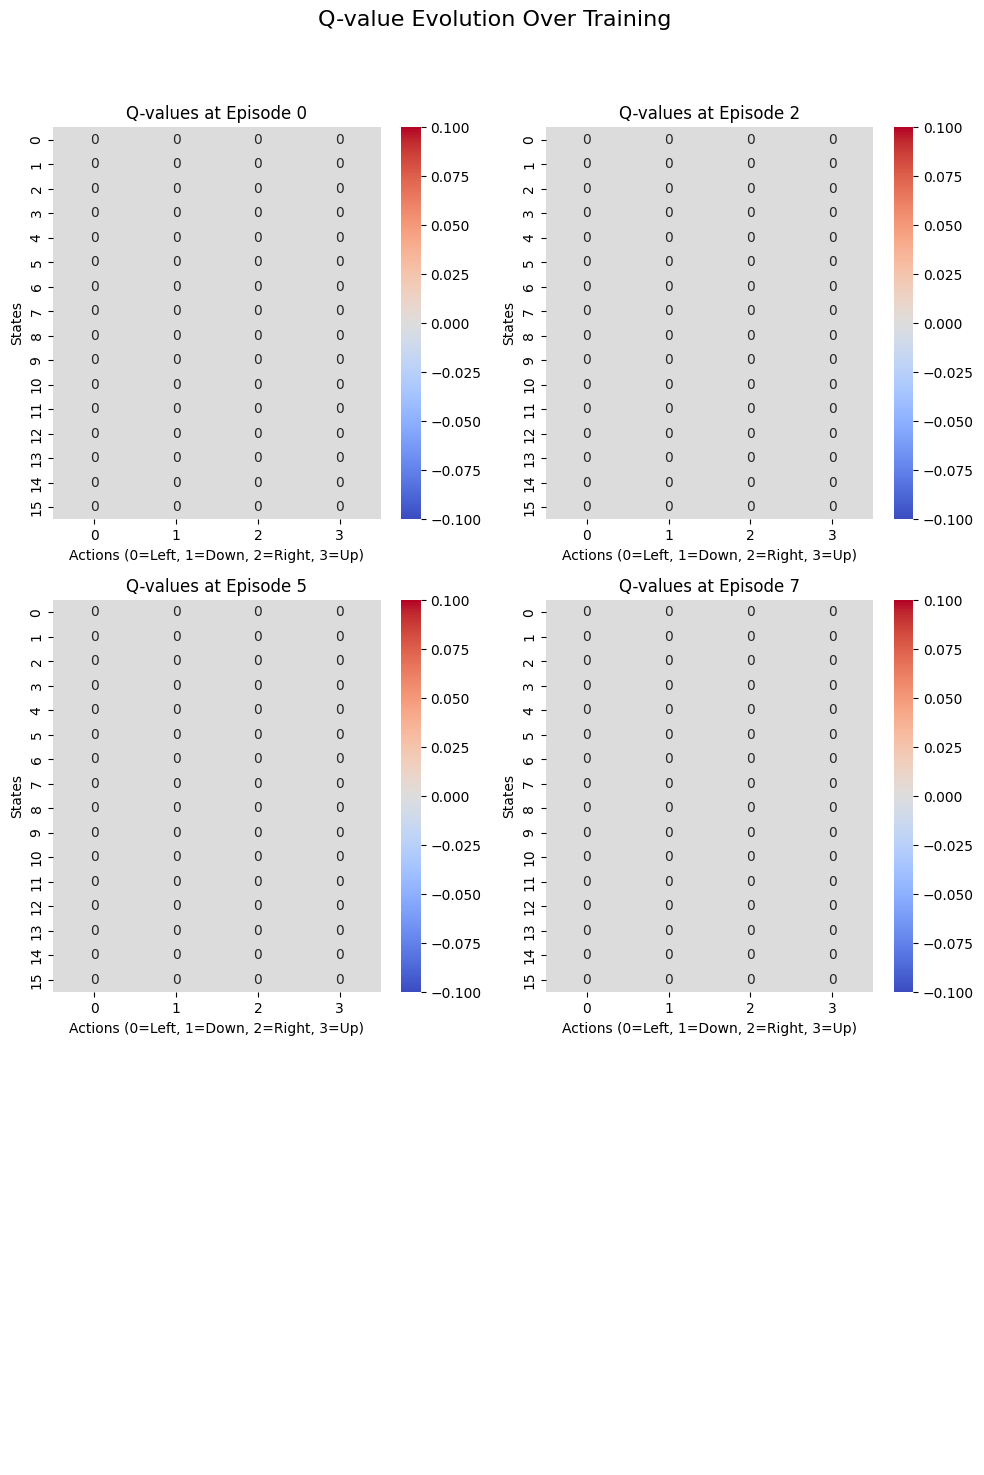

✅ Animation saved as q_table_animation.gif


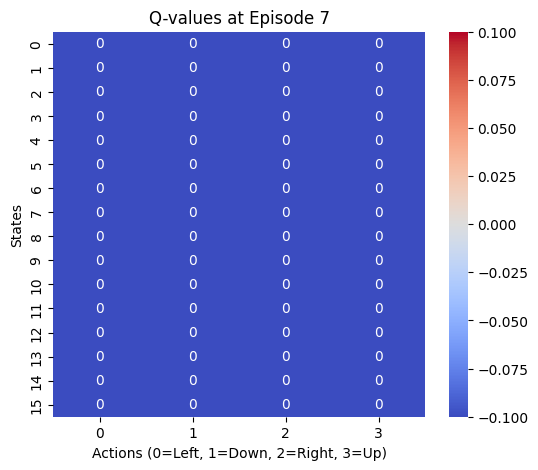

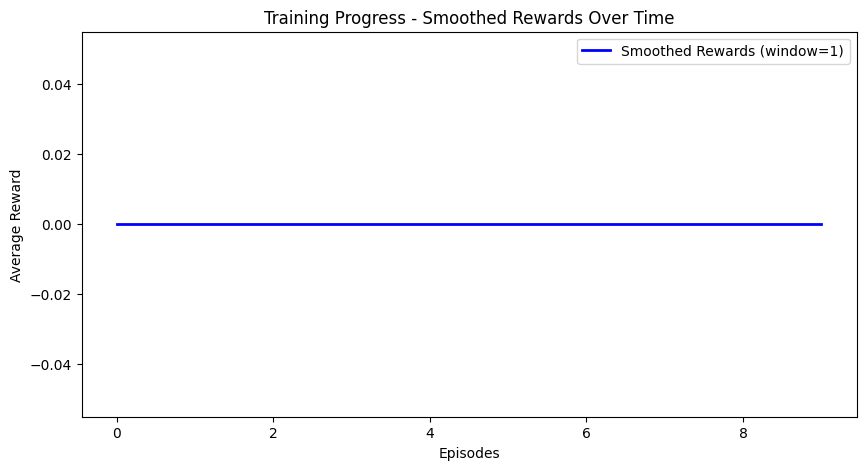

In [6]:
### Shows the best action to take at each state.
getBestActionsPerState(env, Q, ACTION_MAP)

### See the number of times the model visited each state
visualizeStateVisits(state_visits, env)

### See the model learning which action is best at each state
_ = createHeatMap(q_value_snapshots, snapshot_intervals, env)

### Showing the rewards
_ = plotRewards(reward_history, window_size=1)

#### How did the model perform? Why? How should we adjust the model?

In [7]:
env, Q, ACTION_MAP, q_value_snapshots, snapshot_intervals, state_visits, reward_history, _ = reinforcement_learning()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Add functions to see model performance. Hint: How did we analyze the first model? 

Note: To understand why smoothing rewards is important, compare the window_size = 1 vs window_size = 100 graphs


Best Actions Learned by Q-Learning:
↓  ←  ↓  ←
↓  ←  ↓  ←
→  ↓  ↓  ←
←  →  →  ←


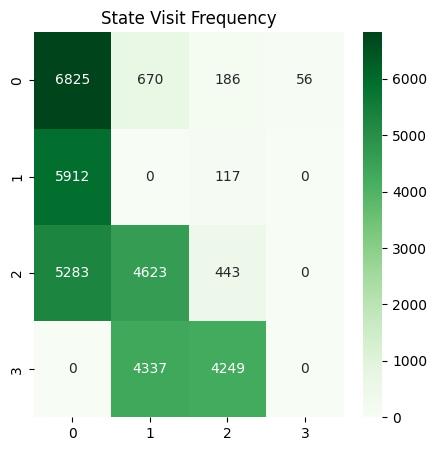

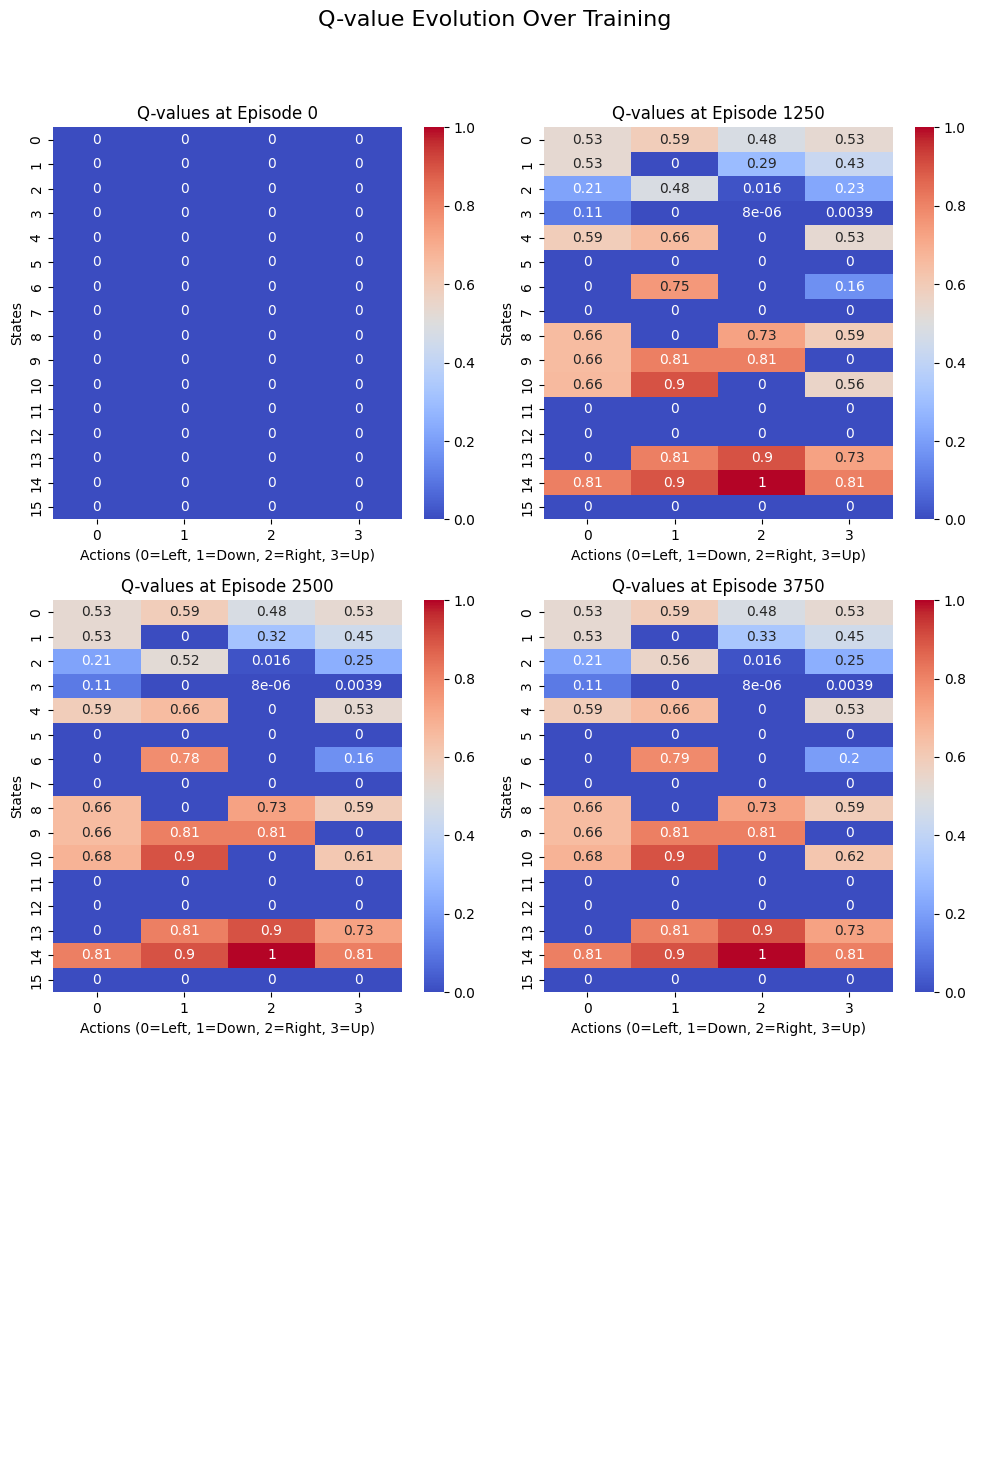

✅ Animation saved as q_table_animation.gif


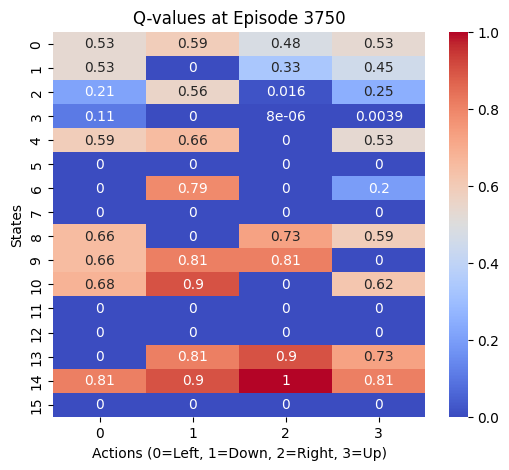

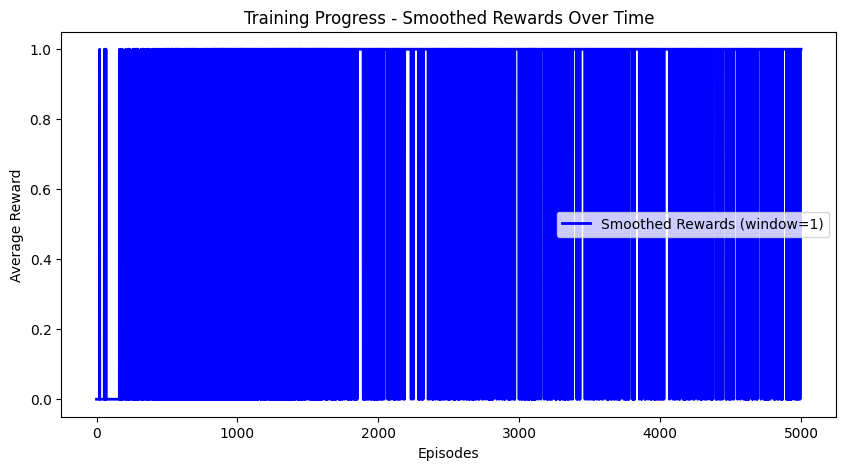

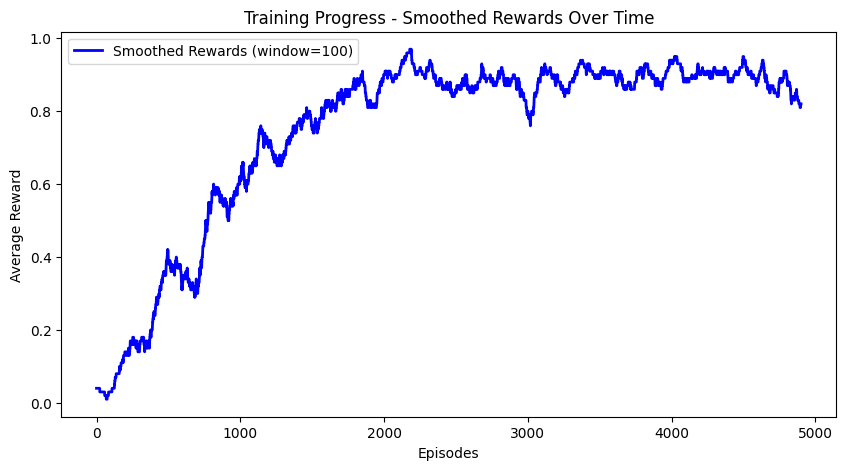

In [8]:
### Shows the best action to take at each state.
getBestActionsPerState(env, Q, ACTION_MAP)

### See the number of times the model visited each state
visualizeStateVisits(state_visits, env)

### See the model learning which action is best at each state
_ = createHeatMap(q_value_snapshots, snapshot_intervals, env)

### Showing the rewards
_ = plotRewards(reward_history, window_size=1)

_ = plotRewards(reward_history, window_size=100)

#### Try Changing Hyperparameter Values

Training with alpha = 0.1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


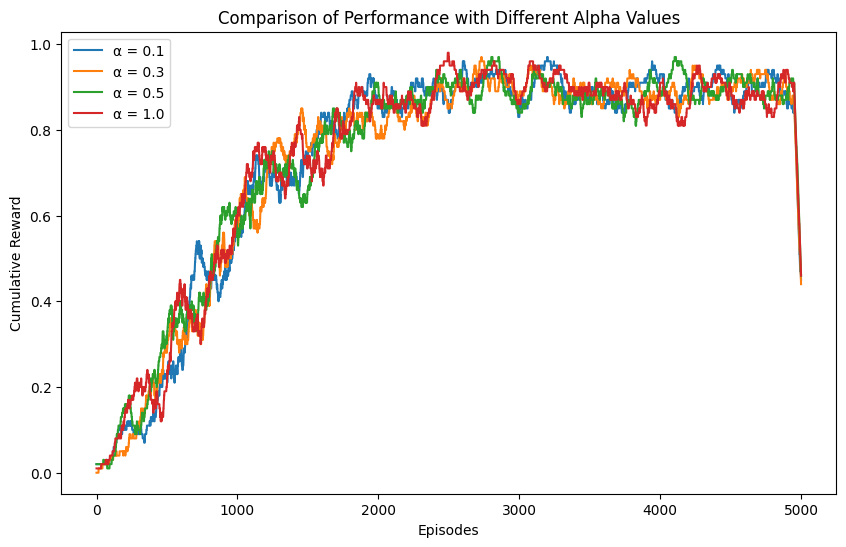

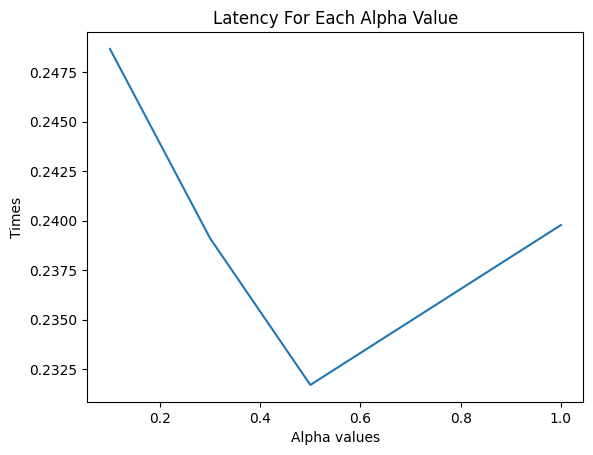

In [9]:
### Current alpha value: 0.1
alpha_values = [0.1, 0.3, 0.5, 1.0]
compare_alpha_values(alpha_values)

Training with gamma = 0.8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


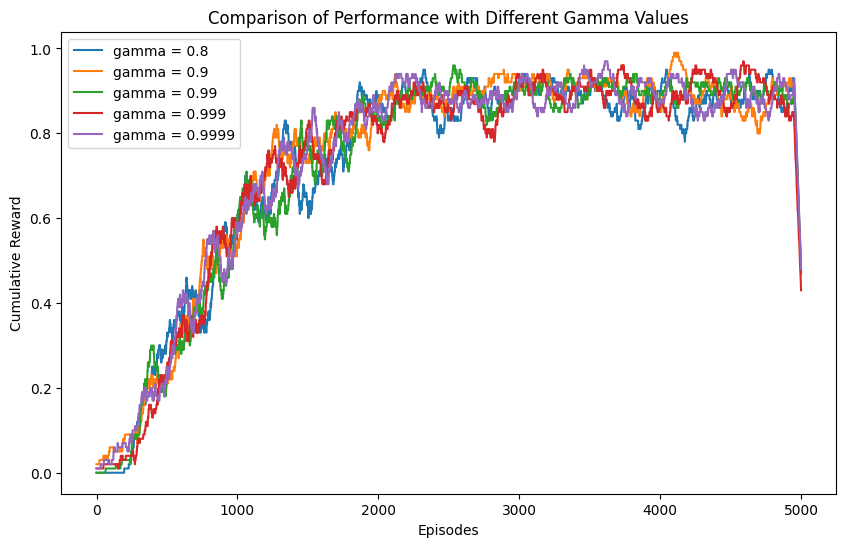

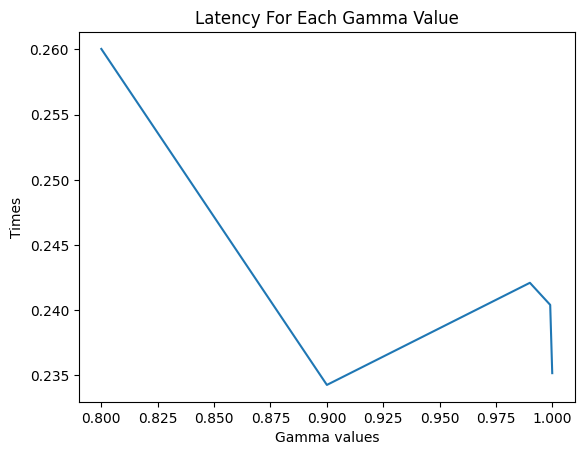

In [11]:
### Current gamma value: 0.9
gamma_values = [0.8, 0.9, 0.99, 0.999, 0.9999]
compare_gamma_values(gamma_values)

Training with epsilon = 0.8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
27

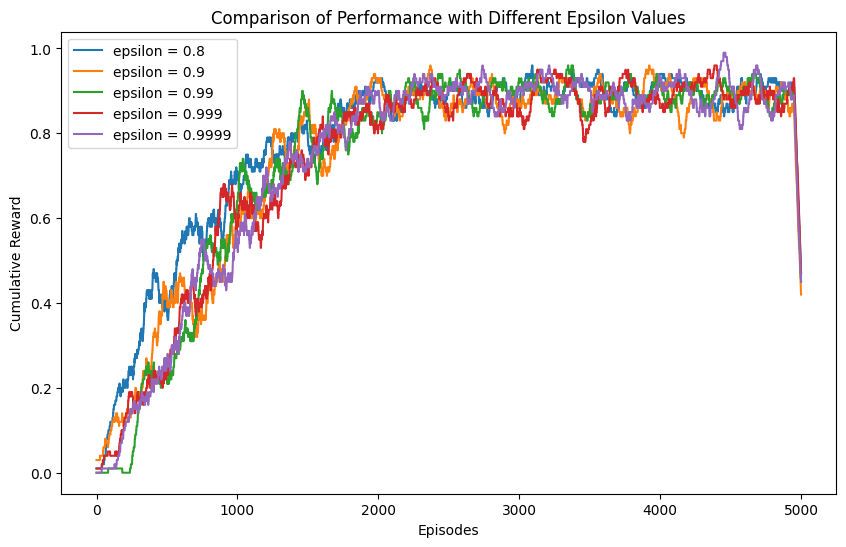

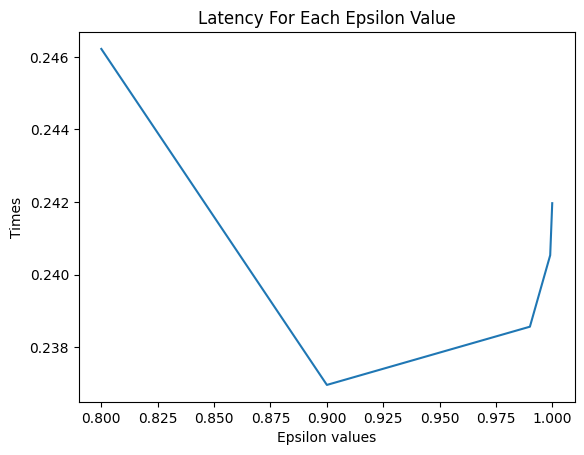

In [12]:
### Current epsilon value: 1.0
epsilon_values = [0.8, 0.9, 0.99, 0.999, 0.9999]
compare_epsilon_values(epsilon_values)

Training with epsilon_decay = 0.8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268


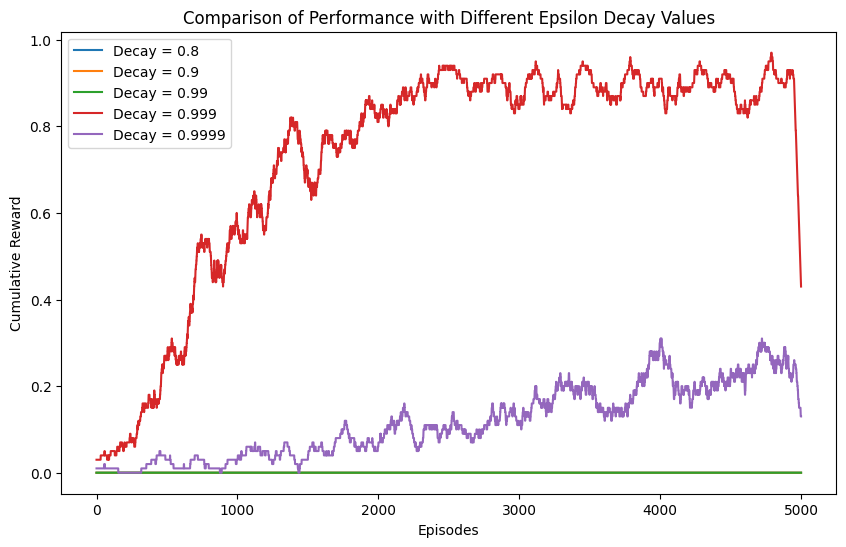

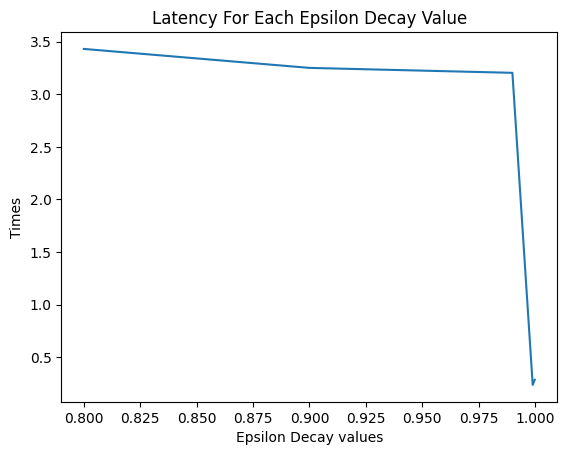

In [13]:
### Current epsilon decay value: 0.999
epsilon_decay_values = [0.8, 0.9, 0.99, 0.999, 0.9999]
compare_epsilon_decay_values(epsilon_decay_values)

How does each hyperparamater affect the model's performace? Which ones would you tune further? Which set of hyperparameters would result in the best model performance? What do you consider as good model performance? Would it be low latency or high accuracy?